In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, GRU, SimpleRNN
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import regularizers
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from keras.initializers import he_normal, glorot_normal
from keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

%matplotlib inline

Jika sebelumnya sudah melihat file LSTM saya, bisa skip dari proses Load Data set sampai sebelum proses Train model

## Load Dataset

In [16]:
pd.set_option('display.max_colwidth', None)

df_tweet = pd.read_csv('./tweet.csv')
df_tweet.head()

,Unnamed: 0,sentimen,tweet
0,0,negatif,"Kata @prabowo Indonesia tidak dihargai bangsa asing! Berita ini ðŸ‘‡ pasti hoax buatan penguasa, ya kan @rockygerung?ðŸ˜œ https://twitter.com/mediaindonesia/status/1117575436337160192?s=21Â â€¦"
1,1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib Luthfi Seharga Mercy? http://dlvr.it/R2pvZVÂ"
2,2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik. #01IndonesiaMaju #JokowiLagi #JokowiMenangTotalDebat pic.twitter.com/W2ythnxsTp"
3,3,positif,"Bagi Sumatera Selatan, Asian Games berdampak pd ekonomi langsung diprediksi mencapai 18,5 triliun. Indonesia maju, Jokowi hebat!"
4,4,negatif,"Negara kita ngutang buat bngun infrastruktur yang udah dipake masyarakat, terus masyarakatnya ngeluh karena negara ngutang, setiap negara itu pasti ngutang, utang bisa dibayar kalo negara dapet penghasilan. Penghasilan negara itu ya dari pajak"


In [17]:
#Drop kolom yang tidak diperlukan

df_tweet = df_tweet.drop(columns=['Unnamed: 0'])
df_tweet.head()

,sentimen,tweet
0,negatif,"Kata @prabowo Indonesia tidak dihargai bangsa asing! Berita ini ðŸ‘‡ pasti hoax buatan penguasa, ya kan @rockygerung?ðŸ˜œ https://twitter.com/mediaindonesia/status/1117575436337160192?s=21Â â€¦"
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib Luthfi Seharga Mercy? http://dlvr.it/R2pvZVÂ"
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik. #01IndonesiaMaju #JokowiLagi #JokowiMenangTotalDebat pic.twitter.com/W2ythnxsTp"
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak pd ekonomi langsung diprediksi mencapai 18,5 triliun. Indonesia maju, Jokowi hebat!"
4,negatif,"Negara kita ngutang buat bngun infrastruktur yang udah dipake masyarakat, terus masyarakatnya ngeluh karena negara ngutang, setiap negara itu pasti ngutang, utang bisa dibayar kalo negara dapet penghasilan. Penghasilan negara itu ya dari pajak"


## EDA

In [18]:
df_tweet

,sentimen,tweet
0,negatif,"Kata @prabowo Indonesia tidak dihargai bangsa asing! Berita ini ðŸ‘‡ pasti hoax buatan penguasa, ya kan @rockygerung?ðŸ˜œ https://twitter.com/mediaindonesia/status/1117575436337160192?s=21Â â€¦"
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib Luthfi Seharga Mercy? http://dlvr.it/R2pvZVÂ"
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik. #01IndonesiaMaju #JokowiLagi #JokowiMenangTotalDebat pic.twitter.com/W2ythnxsTp"
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak pd ekonomi langsung diprediksi mencapai 18,5 triliun. Indonesia maju, Jokowi hebat!"
4,negatif,"Negara kita ngutang buat bngun infrastruktur yang udah dipake masyarakat, terus masyarakatnya ngeluh karena negara ngutang, setiap negara itu pasti ngutang, utang bisa dibayar kalo negara dapet penghasilan. Penghasilan negara itu ya dari pajak"
...,...,...
1810,netral,Negarawan sejati sll bangga dan mengedepankan harga diri bangsanya yg berdaulat #2019GantiPresiden
1811,netral,1. HRS ceramah di Damai Indonesiaku 2. Perekonomian makin membaik. #PutihkanGBK
1812,netral,Mari bangun bangsa dgn mendukung perekonomian negara bersama Pak Jokowi. Ayo kerja! https://twitter.com/KaskusLoker/status/1111643312241295363Â â€¦
1813,netral,"Bantu majukan perekonomian bangsa bersama Pak Jokowi, yuk! https://twitter.com/BKNSquare/status/1113655944955588610Â â€¦"


In [19]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentimen  1815 non-null   object
 1   tweet     1815 non-null   object
dtypes: object(2)
memory usage: 28.5+ KB


### Check Validate Rows

In [20]:
# Cek duplicate rows

duplicate_rows = df_tweet[df_tweet.duplicated(subset='tweet')]

if not duplicate_rows.empty:
    print('Baris duplikat ditemukan: ')
    print(duplicate_rows)
else:
    print('Baris duplikat tidak ditemukan.')

Baris duplikat tidak ditemukan.


### Check Imbalance Data

- Count negative, positive, and netral sentiment
- Balanced

In [21]:
sentimen_negatif = df_tweet['sentimen'].value_counts()['negatif']
sentimen_positif = df_tweet['sentimen'].value_counts()['positif']
sentimen_netral = df_tweet['sentimen'].value_counts()['netral']

print('Jumlah sentimen Negatif: ', sentimen_negatif)
print('Jumlah sentimen Positif: ', sentimen_positif)
print('Jumlah sentimen Netral: ', sentimen_netral)
print('Total rows:', df_tweet.shape[0])

Jumlah sentimen Negatif:  596
Jumlah sentimen Positif:  612
Jumlah sentimen Netral:  607
Total rows: 1815


### Visualization before Preprocessing Data

In [22]:
!pip install wordcloud

#### WordCloud

- Negative Sentiment

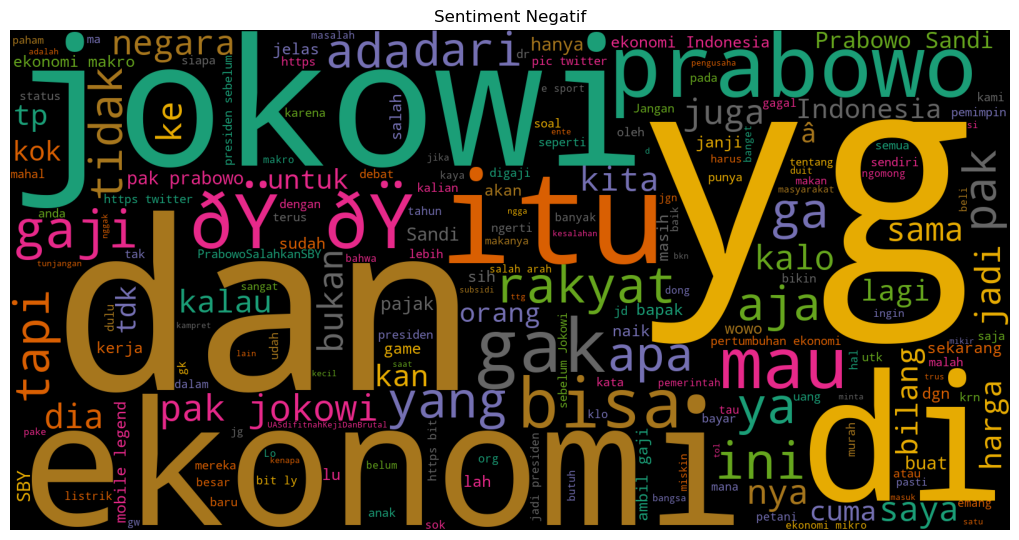

In [23]:
from wordcloud import WordCloud

sentimen_negatif = df_tweet.loc[(df_tweet['sentimen'] == "negatif")]
word_negatif = pd.Series(' '.join(sentimen_negatif['tweet']).split())
text_posi = ' '.join(word_negatif)

wordcloud_neg = WordCloud(background_color='black', mode="RGB", width=1600, height=800, colormap="Dark2").generate(text_posi)
plt.figure(figsize=(10,10))
plt.title('Sentiment Negatif')
plt.imshow(wordcloud_neg)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

- Positive Sentiment

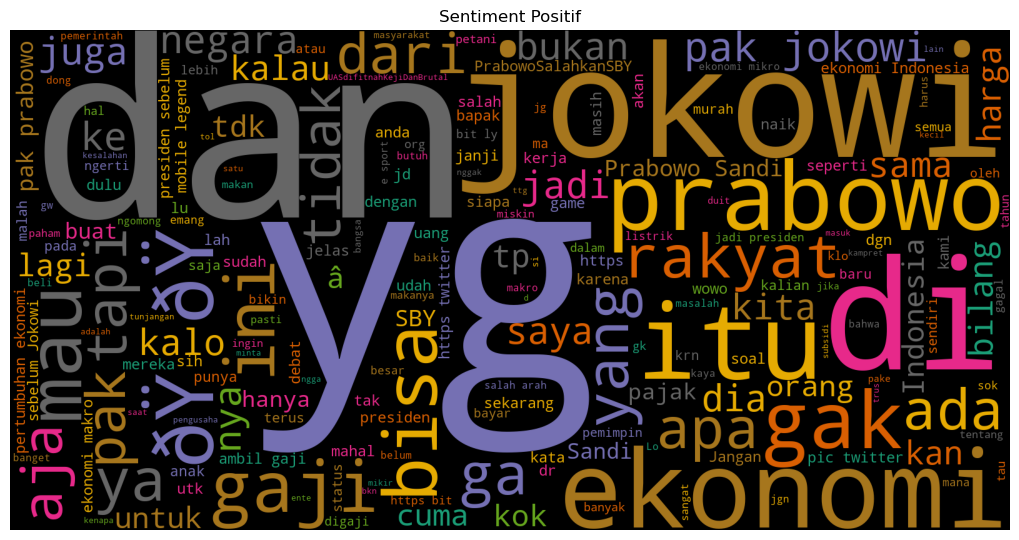

In [24]:
from wordcloud import WordCloud

sentimen_positif = df_tweet.loc[(df_tweet['sentimen'] == "positif")]
word_positif = pd.Series(' '.join(sentimen_positif['tweet']).split())
text_positif = ' '.join(word_positif)

wordcloud_positif = WordCloud(background_color='black', mode="RGB", width=1600, height=800, colormap="Dark2").generate(text_posi)
plt.figure(figsize=(10,10))
plt.title('Sentiment Positif')
plt.imshow(wordcloud_positif)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

- Netral Sentiment

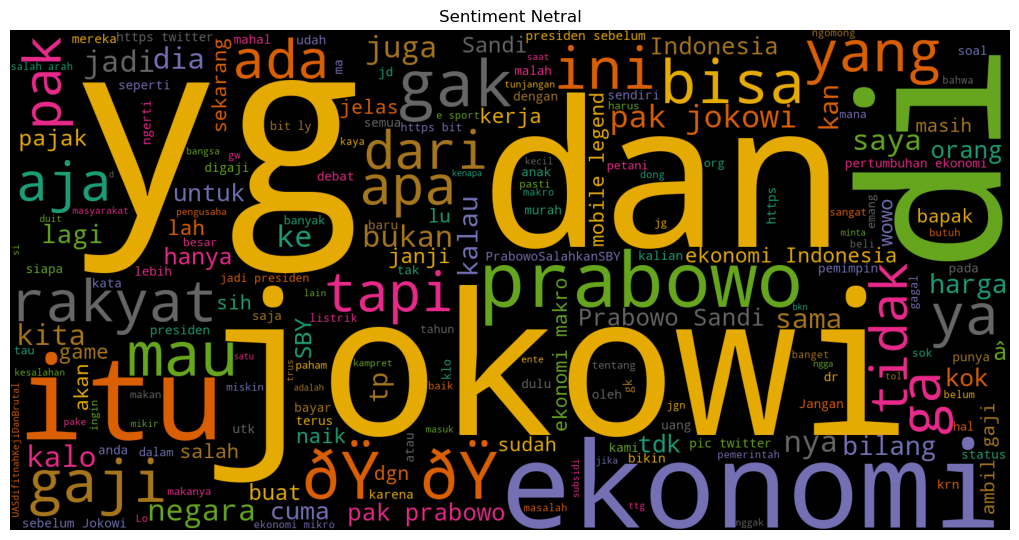

In [25]:
from wordcloud import WordCloud

sentimen_netral = df_tweet.loc[(df_tweet['sentimen'] == "netral")]
word_netral = pd.Series(' '.join(sentimen_netral['tweet']).split())
text_netral = ' '.join(word_netral)

wordcloud_netral = WordCloud(background_color='black', mode="RGB", width=1600, height=800, colormap="Dark2").generate(text_posi)
plt.figure(figsize=(10,10))
plt.title('Sentiment Netral')
plt.imshow(wordcloud_netral)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Top 10 Words Frequency Before Preprocessing

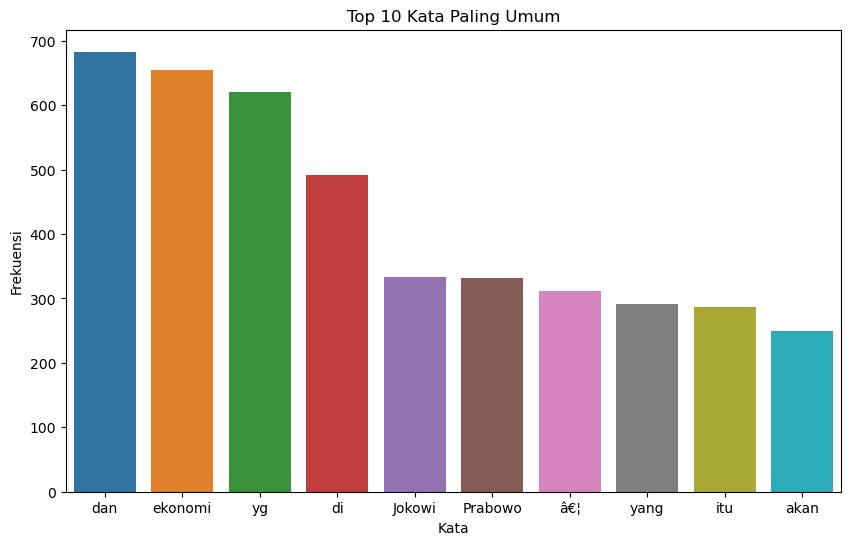

In [26]:
from collections import Counter
words = ' '.join(df_tweet['tweet']).split()
word_freq = Counter(words)

common_words = word_freq.most_common(10)
common_words

plt.figure(figsize=(10, 6))
sns.barplot(x=[word[0] for word in common_words], y=[word[1] for word in common_words])
plt.title('Top 10 Kata Paling Umum')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.show()

## Text Preprocessing & Cleaning

In [27]:
!pip install nltk

###  Regex (Remove URL, Special Character and Punctuation)

In [28]:
tweet_list = df_tweet['tweet'].tolist()

In [29]:
def regex_remover(tweet):
    
    #Menghapus pic.twitter.com/
    reg_clean = re.sub(r'pic\.twitter\.com/[\w]+', '', tweet)
    
    #Menghapus Emoji
    reg_clean = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U0001FB00-\U0001FBFF\U0001FC00-\U0001FCFF\U0001FD00-\U0001FDFF\U0001FE00-\U0001FEFF\U0001FF00-\U0001FFFF]'
, '', reg_clean)
    
    #Menghapus Karakter Non-ASCII:
    reg_clean = re.sub(r'[^\x00-\x7F]+', '', reg_clean)
    
    #Menghapus Hashtag
    reg_clean = re.sub(r'#\w+', '', reg_clean)
    
    #Menghapus pola @..com
    reg_clean = re.sub(r'via @\w+\.com', '', reg_clean)
    
    reg_clean = re.sub(r'@', '', reg_clean)
    
    #Menghapus special character & punctuation, case folding
    reg_clean = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)" ," ",reg_clean.lower()).split())
    
    return reg_clean.strip()

In [30]:
cleaned_tweet = []

for idx in range(len(tweet_list)):
    cleaned = regex_remover(tweet_list[idx])
    cleaned_tweet.append(cleaned)

print('Hasil sebelumnya')
print('='*50)
display(tweet_list[20:24])
print('Hasil akhir')
print('='*50)
display(cleaned_tweet[20:24])

Hasil sebelumnya


["Assalamu'alaikum.  Saya tahu 1 suara itu sgt berharga dlm upaya memenangkan 02 @prabowo & @sandiuno saya hrs merelakan suara dikarenakan berada di Jkt namun KTP daerah. Semoga suara saya yg tdk disertakan bisa terbalaskan dgn doa. Semoga Allah SWT mengabulkan itu. Aamiin ya Rabb https://twitter.com/sandiuno/status/1117101696696455173Â\xa0â€¦",
 'Jika Terpilih, Prabowo-Sandiaga Janji Tak Ambil Gaji  -  Kita tahu mereka orang-orang yang superkaya, mbok ya rendah hatilah jangan menyatakan kata2 berkonotasi angkuh !!  https://m.detik.com/news/berita/d-4509616/jika-terpilih-prabowo-sandiaga-janji-tak-ambil-gaji?utm_content=detikcom&utm_term=echobox&utm_medium=oa&utm_campaign=detikcomsocmed&utm_source=Twitter#Echobox=1555171378Â\xa0â€¦',
 '@prabowo apa bapak  gak menghargai relawan yg puasa dan tirakatan munajad semalam suntuk berdoa untuk kemenangan 02 ? Mhn dibalas tweet dan kontribusi ngopi rokok dll mereka yg  tirakat/mujahadah .Jika tdk maka 02 akan gagal.Ayo semua  tirakat/ munajad.I

Hasil akhir


['assalamu alaikum saya tahu 1 suara itu sgt berharga dlm upaya memenangkan 02 prabowo sandiuno saya hrs merelakan suara dikarenakan berada di jkt namun ktp daerah semoga suara saya yg tdk disertakan bisa terbalaskan dgn doa semoga allah swt mengabulkan itu aamiin ya rabb',
 'jika terpilih prabowo sandiaga janji tak ambil gaji kita tahu mereka orang orang yang superkaya mbok ya rendah hatilah jangan menyatakan kata2 berkonotasi angkuh',
 'prabowo apa bapak gak menghargai relawan yg puasa dan tirakatan munajad semalam suntuk berdoa untuk kemenangan 02 mhn dibalas tweet dan kontribusi ngopi rokok dll mereka yg tirakat mujahadah jika tdk maka 02 akan gagal ayo semua tirakat munajad in',
 'prabowo sandi menang otomatis kita ikut bersedekah bagi kaum farkir miskin dan dhuafa melalui gaji mereka berfua yg tidak akan diambil dan akan disedekahkan']

### Replace Slangword

In [31]:
df_lexicon = pd.read_csv('./colloquial-indonesian-lexicon.csv')
df_lexicon.head()

,slang,formal,In-dictionary,context,category1,category2,category3
0,woww,wow,1,wow,elongasi,0,0
1,aminn,amin,1,"Selamat ulang tahun kakak tulus semoga panjang umur kakak,sehat selalu juga,murah rezeki ya kakak dan jangan sombong kalo sukses di karirnya aminn @tulusm",elongasi,0,0
2,met,selamat,1,Met hari netaas kak!? Wish you all the best @tulusm,abreviasi,0,0
3,netaas,menetas,1,Met hari netaas kak!? Wish you all the best @tulusm,afiksasi,elongasi,0
4,keberpa,keberapa,0,Birthday yg keberpa kak?,abreviasi,0,0


In [32]:
# drop kolom yang tidak diperlukan
df_lexicon = df_lexicon.drop(columns=['In-dictionary', 'context', 'category1', 'category2', 'category3'])
df_lexicon

,slang,formal
0,woww,wow
1,aminn,amin
2,met,selamat
3,netaas,menetas
4,keberpa,keberapa
...,...,...
15001,gataunya,enggak taunya
15002,gtau,enggak tau
15003,gatau,enggak tau
15004,fans2,fan-fan


In [33]:
slang_dict = dict(zip(df_lexicon['slang'], df_lexicon['formal']))

def replace_slang(text, slang_dict):
    words = text.split()
    replace_words = [slang_dict.get(word, word) for word in words]
    return ' '.join (replace_words)

In [34]:
new_cleaned_tweet = [replace_slang(text, slang_dict) for text in cleaned_tweet]


print('Hasil sebelumnya')
print('='*50)
display(cleaned_tweet[20:25])
print('Hasil akhir')
print('='*50)
display(new_cleaned_tweet[20:25])

Hasil sebelumnya


['assalamu alaikum saya tahu 1 suara itu sgt berharga dlm upaya memenangkan 02 prabowo sandiuno saya hrs merelakan suara dikarenakan berada di jkt namun ktp daerah semoga suara saya yg tdk disertakan bisa terbalaskan dgn doa semoga allah swt mengabulkan itu aamiin ya rabb',
 'jika terpilih prabowo sandiaga janji tak ambil gaji kita tahu mereka orang orang yang superkaya mbok ya rendah hatilah jangan menyatakan kata2 berkonotasi angkuh',
 'prabowo apa bapak gak menghargai relawan yg puasa dan tirakatan munajad semalam suntuk berdoa untuk kemenangan 02 mhn dibalas tweet dan kontribusi ngopi rokok dll mereka yg tirakat mujahadah jika tdk maka 02 akan gagal ayo semua tirakat munajad in',
 'prabowo sandi menang otomatis kita ikut bersedekah bagi kaum farkir miskin dan dhuafa melalui gaji mereka berfua yg tidak akan diambil dan akan disedekahkan',
 'kepercayaan hanya diberikan pd mrk yg berpengalaman seorang jokowi memiliki wakil yg berpengalaman dibidang ekonomi coblos yuk 01 ya']

Hasil akhir


['assalamu alaikum saya tahu 1 suara itu sangat berharga dalam upaya memenangkan 02 prabowo sandiuno saya harus merelakan suara dikarenakan berada di jakarta namun ktp daerah semoga suara saya yang tidak disertakan bisa terbalaskan dengan doa semoga allah swt mengabulkan itu amin ya rabb',
 'jika terpilih prabowo sandiaga janji tak ambil gaji kita tahu mereka orang orang yang superkaya mbok ya rendah hatilah jangan menyatakan kata-kata berkonotasi angkuh',
 'prabowo apa bapak enggak menghargai relawan yang puasa dan tirakatan munajad semalam suntuk berdoa untuk kemenangan 02 mhn dibalas tweet dan kontribusi ngopi rokok dll mereka yang tirakat mujahadah jika tidak maka 02 akan gagal ayo semua tirakat munajad ini',
 'prabowo sandi menang otomatis kita ikut bersedekah bagi kaum farkir miskin dan dhuafa melalui gaji mereka berfua yang tidak akan diambil dan akan disedekahkan',
 'kepercayaan hanya diberikan pada mereka yang berpengalaman seorang jokowi memiliki wakil yang berpengalaman dibi

### Combined with Other Slang

In [35]:
import json

with open('./combined_slang_words.txt', 'r') as file:
    data = json.load(file)

In [36]:
df_combined_slang = pd.DataFrame(list(data.items()), columns=["slang", "formal"])
df_combined_slang

,slang,formal
0,abis,habis
1,ad,ada
2,adlh,adalah
3,afaik,as far as i know
4,ahaha,haha
...,...,...
1030,via,lewat
1031,sdh,sudah
1032,org,orang
1033,ma,sama


In [37]:
slang_dict = dict(zip(df_combined_slang['slang'], df_combined_slang['formal']))

def combined_new_slang(text, slang_dict):
    words = text.split()
    combined_new_words = [slang_dict.get(word, word) for word in words]
    return ' '.join (combined_new_words)

In [38]:
combined_tweet = [combined_new_slang(text, slang_dict) for text in new_cleaned_tweet]


print('Hasil sebelumnya')
print('='*50)
display(new_cleaned_tweet[20:25])
print('Hasil akhir')
print('='*50)
display(combined_tweet[20:25])

Hasil sebelumnya


['assalamu alaikum saya tahu 1 suara itu sangat berharga dalam upaya memenangkan 02 prabowo sandiuno saya harus merelakan suara dikarenakan berada di jakarta namun ktp daerah semoga suara saya yang tidak disertakan bisa terbalaskan dengan doa semoga allah swt mengabulkan itu amin ya rabb',
 'jika terpilih prabowo sandiaga janji tak ambil gaji kita tahu mereka orang orang yang superkaya mbok ya rendah hatilah jangan menyatakan kata-kata berkonotasi angkuh',
 'prabowo apa bapak enggak menghargai relawan yang puasa dan tirakatan munajad semalam suntuk berdoa untuk kemenangan 02 mhn dibalas tweet dan kontribusi ngopi rokok dll mereka yang tirakat mujahadah jika tidak maka 02 akan gagal ayo semua tirakat munajad ini',
 'prabowo sandi menang otomatis kita ikut bersedekah bagi kaum farkir miskin dan dhuafa melalui gaji mereka berfua yang tidak akan diambil dan akan disedekahkan',
 'kepercayaan hanya diberikan pada mereka yang berpengalaman seorang jokowi memiliki wakil yang berpengalaman dibi

Hasil akhir


['assalamu alaikum saya tahu 1 suara itu sangat berharga dalam upaya memenangkan 02 prabowo sandiuno saya harus merelakan suara dikarenakan berada di jakarta namun ktp daerah semoga suara saya yang tidak disertakan bisa terbalaskan dengan doa semoga allah swt mengabulkan itu amin iya rabb',
 'jika terpilih prabowo sandiaga janji tidak ambil gaji kita tahu mereka orang orang yang superkaya mbok iya rendah hatilah jangan menyatakan kata-kata berkonotasi angkuh',
 'prabowo apa bapak tidak menghargai relawan yang puasa dan tirakatan munajad semalam suntuk berdoa untuk kemenangan 02 mohon dibalas tweet dan kontribusi ngopi rokok dan lain-lain mereka yang tirakat mujahadah jika tidak maka 02 akan gagal ayo semua tirakat munajad ini',
 'prabowo sandi menang otomatis kita ikut bersedekah bagi kaum farkir miskin dan dhuafa melalui gaji mereka berfua yang tidak akan diambil dan akan disedekahkan',
 'kepercayaan hanya diberikan pada mereka yang berpengalaman seorang jokowi memiliki wakil yang ber

## EDA After Preprocessing

In [39]:
df_tweet['preproceed_tweet'] = combined_tweet
df_tweet

,sentimen,tweet,preproceed_tweet
0,negatif,"Kata @prabowo Indonesia tidak dihargai bangsa asing! Berita ini ðŸ‘‡ pasti hoax buatan penguasa, ya kan @rockygerung?ðŸ˜œ https://twitter.com/mediaindonesia/status/1117575436337160192?s=21Â â€¦",kata prabowo indonesia tidak dihargai bangsa asing berita ini pasti isu bohong buatan penguasa iya kan rockygerung
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib Luthfi Seharga Mercy? http://dlvr.it/R2pvZVÂ",batuan langka tasbih jokowi hadiah dari habib luthfi seharga mercy
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik. #01IndonesiaMaju #JokowiLagi #JokowiMenangTotalDebat pic.twitter.com/W2ythnxsTp",di era jokowi ekonomi indonesia semakin baik
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak pd ekonomi langsung diprediksi mencapai 18,5 triliun. Indonesia maju, Jokowi hebat!",bagi sumatera selatan asian games berdampak pada ekonomi langsung diprediksi mencapai 18 5 triliun indonesia maju jokowi hebat
4,negatif,"Negara kita ngutang buat bngun infrastruktur yang udah dipake masyarakat, terus masyarakatnya ngeluh karena negara ngutang, setiap negara itu pasti ngutang, utang bisa dibayar kalo negara dapet penghasilan. Penghasilan negara itu ya dari pajak",negara kita hutang buat bangun infrastruktur yang sudah dipakai masyarakat terus masyarakatnya ngeluh karena negara hutang setiap negara itu pasti hutang utang bisa dibayar kalau negara dapat penghasilan penghasilan negara itu iya dari pajak
...,...,...,...
1810,netral,Negarawan sejati sll bangga dan mengedepankan harga diri bangsanya yg berdaulat #2019GantiPresiden,negarawan sejati selalu bangga dan mengedepankan harga diri bangsanya yang berdaulat
1811,netral,1. HRS ceramah di Damai Indonesiaku 2. Perekonomian makin membaik. #PutihkanGBK,1 harus ceramah di damai indonesiaku 2 perekonomian makin membaik
1812,netral,Mari bangun bangsa dgn mendukung perekonomian negara bersama Pak Jokowi. Ayo kerja! https://twitter.com/KaskusLoker/status/1111643312241295363Â â€¦,mari bangun bangsa dengan mendukung perekonomian negara bersama bapak jokowi ayo kerja
1813,netral,"Bantu majukan perekonomian bangsa bersama Pak Jokowi, yuk! https://twitter.com/BKNSquare/status/1113655944955588610Â â€¦",bantu majukan perekonomian bangsa bersama bapak jokowi yuk


### Visualization after Preprocessing Data

#### WordCloud

- Negative Sentiment

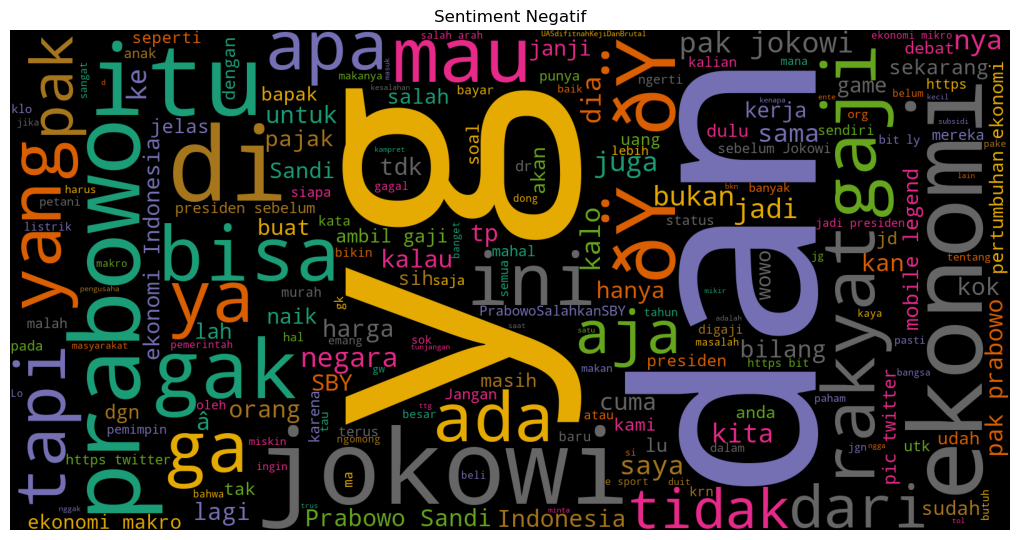

In [40]:
from wordcloud import WordCloud

cleaned_sentimen_negatif = df_tweet.loc[(df_tweet['sentimen'] == "negatif")]
cleaned_word_negatif = pd.Series(' '.join(cleaned_sentimen_negatif['preproceed_tweet']).split())
cleaned_text_neg = ' '.join(cleaned_word_negatif)

cleaned_wordcloud_neg = WordCloud(background_color='black', mode="RGB", width=1600, height=800, colormap="Dark2").generate(text_posi)
plt.figure(figsize=(10,10))
plt.title('Sentiment Negatif')
plt.imshow(cleaned_wordcloud_neg)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

- Positive Sentiment

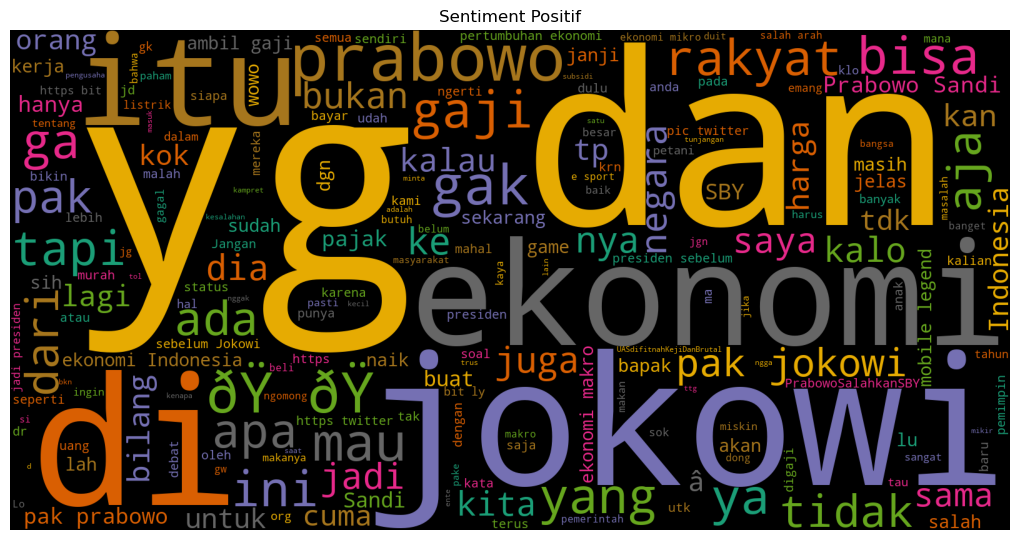

In [41]:
from wordcloud import WordCloud

cleaned_sentimen_positif = df_tweet.loc[(df_tweet['sentimen'] == "positif")]
cleaned_word_positif = pd.Series(' '.join(cleaned_sentimen_positif['preproceed_tweet']).split())
cleaned_text_pos = ' '.join(cleaned_word_positif)

cleaned_wordcloud_pos = WordCloud(background_color='black', mode="RGB", width=1600, height=800, colormap="Dark2").generate(text_posi)
plt.figure(figsize=(10,10))
plt.title('Sentiment Positif')
plt.imshow(cleaned_wordcloud_pos)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

- Netral Sentiment

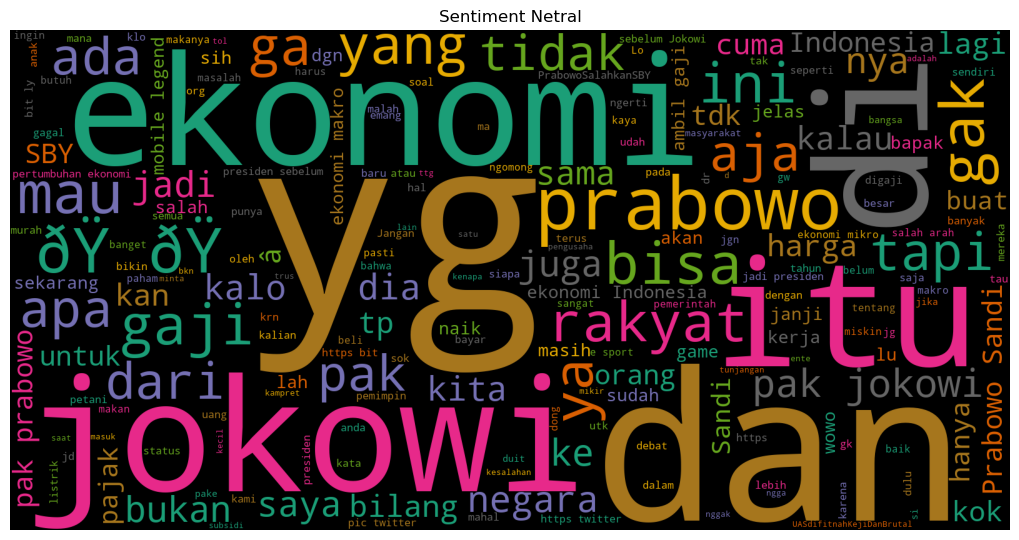

In [42]:
from wordcloud import WordCloud

cleaned_sentimen_netral = df_tweet.loc[(df_tweet['sentimen'] == "netral")]
cleaned_word_netral = pd.Series(' '.join(cleaned_sentimen_netral['preproceed_tweet']).split())
cleaned_text_net = ' '.join(cleaned_word_netral)

cleaned_wordcloud_net = WordCloud(background_color='black', mode="RGB", width=1600, height=800, colormap="Dark2").generate(text_posi)
plt.figure(figsize=(10,10))
plt.title('Sentiment Netral')
plt.imshow(cleaned_wordcloud_net)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Top 10 Word Frequency After Prepropcessing

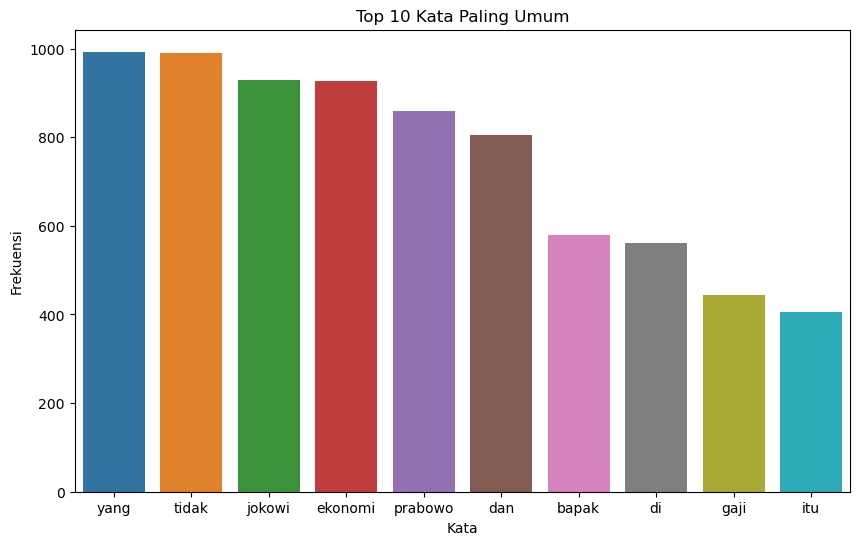

In [43]:
from collections import Counter
words = ' '.join(df_tweet['preproceed_tweet']).split()
word_freq = Counter(words)

common_words = word_freq.most_common(10)
common_words

plt.figure(figsize=(10, 6))
sns.barplot(x=[word[0] for word in common_words], y=[word[1] for word in common_words])
plt.title('Top 10 Kata Paling Umum')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.show()

Pada beberapa percobaan sebelumnya, saya sudah melakukan stopwords, di sini, untuk stopword tidak saya lakukan lagi karena berpotensi menyebabkan pergeseran makna kalimat.

Contoh:
kata prabowo indonesia tidak dihargai bangsa asing berita ini pasti hoax buatan penguasa ya kan rockygerung

Setelah Stopword:
kata prabowo indonesia dihargai bangsa asing berita ini pasti hoax buatan penguasa ya kan rockygerung

Setelah stopword, kata 'tidak' jadi dihilangkan. Ini akan mengubah sentimen yang tadinya negatif, bisa menjadi positif atau netral. Maka dari itu, saya tidak menggunakan stopword

## Text Normalization

### Stemming Sastrawi

In [44]:
!pip install Sastrawi

In [45]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
def stemming_indonesian_sastrawi(tweet):
    # Membuat contoh dari stemmer
    stemmer = StemmerFactory().create_stemmer()
    
    # Panggil stemming
    stemmed_text = stemmer.stem(tweet)
    return stemmed_text

In [46]:
stemmed_tweets = []

for idx in range(len(combined_tweet)):
    stemmed = stemming_indonesian_sastrawi(combined_tweet[idx])
    stemmed_tweets.append(stemmed)
    
print('Hasil sebelumnya')
print('='*50)
display(combined_tweet[190:199])
print('Hasil akhir')
print('='*50)
display(stemmed_tweets[190:199])

Hasil sebelumnya


['lalu harga tiket pesawat kapan diturunkan bapak saya sangat brharap besar dalam aspek ini trlbh dengan mahal nya harga tiket pesawat terbang yang amat tinggi mahal tarif biaya expdisi antar kota pun ikut melonjak naik',
 'paling parah malaysia mbak bayangkan 2jt orang harus beetumpu di 3 tps apakah kita sebagai warga negara tidak boleh kritik dan tidak boleh marah kalau lihat para pelaksana swperti itu sedangkan mereka di gaji olh uang negara',
 'iya daripada memikirkan yang kayak begitu lebih baik memikirkan hal yang mendasar dulu dong ekonomi dan lain-lain lah kalau ketagihan game online bikin malas sgl nya di suruh wirid ke masjid bahkan nongkrong di warnet bergayalah sesuai isi kantong',
 'kata die zaman jokowi ekonomi anjlok tapi punya gadget sebanyak itu belum lagi bayar wifi terus dia bilang anjlok dan serba mahal itu apa',
 'janji tidak ambil gaji jika terpilih prabowo sandi ikuti jejak para presiden terkenal ini',
 'iya memang lebih kecil tapi pngetahuan tata kelola ekonomi 

Hasil akhir


['lalu harga tiket pesawat kapan turun bapak saya sangat brharap besar dalam aspek ini trlbh dengan mahal nya harga tiket pesawat terbang yang amat tinggi mahal tarif biaya expdisi antar kota pun ikut lonjak naik',
 'paling parah malaysia mbak bayang 2jt orang harus beetumpu di 3 tps apakah kita bagai warga negara tidak boleh kritik dan tidak boleh marah kalau lihat para laksana swperti itu sedang mereka di gaji olh uang negara',
 'iya daripada pikir yang kayak begitu lebih baik pikir hal yang dasar dulu dong ekonomi dan lain lah kalau tagih game online bikin malas sgl nya di suruh wirid ke masjid bahkan nongkrong di warnet gaya sesuai isi kantong',
 'kata die zaman jokowi ekonomi anjlok tapi punya gadget banyak itu belum lagi bayar wifi terus dia bilang anjlok dan serba mahal itu apa',
 'janji tidak ambil gaji jika pilih prabowo sandi ikut jejak para presiden kenal ini',
 'iya memang lebih kecil tapi pngetahuan tata kelola ekonomi negara jauh kelas',
 'prabowo sudah buat apa untuk rak

## After Stemming

In [48]:
df_tweet['stemmed_tweet'] = stemmed_tweets
df_tweet.head()

,sentimen,tweet,preproceed_tweet,stemmed_tweet
0,negatif,"Kata @prabowo Indonesia tidak dihargai bangsa asing! Berita ini ðŸ‘‡ pasti hoax buatan penguasa, ya kan @rockygerung?ðŸ˜œ https://twitter.com/mediaindonesia/status/1117575436337160192?s=21Â â€¦",kata prabowo indonesia tidak dihargai bangsa asing berita ini pasti isu bohong buatan penguasa iya kan rockygerung,kata prabowo indonesia tidak harga bangsa asing berita ini pasti isu bohong buat kuasa iya kan rockygerung
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib Luthfi Seharga Mercy? http://dlvr.it/R2pvZVÂ",batuan langka tasbih jokowi hadiah dari habib luthfi seharga mercy,batu langka tasbih jokowi hadiah dari habib luthfi harga mercy
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik. #01IndonesiaMaju #JokowiLagi #JokowiMenangTotalDebat pic.twitter.com/W2ythnxsTp",di era jokowi ekonomi indonesia semakin baik,di era jokowi ekonomi indonesia makin baik
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak pd ekonomi langsung diprediksi mencapai 18,5 triliun. Indonesia maju, Jokowi hebat!",bagi sumatera selatan asian games berdampak pada ekonomi langsung diprediksi mencapai 18 5 triliun indonesia maju jokowi hebat,bagi sumatera selatan asi games dampak pada ekonomi langsung prediksi capai 18 5 triliun indonesia maju jokowi hebat
4,negatif,"Negara kita ngutang buat bngun infrastruktur yang udah dipake masyarakat, terus masyarakatnya ngeluh karena negara ngutang, setiap negara itu pasti ngutang, utang bisa dibayar kalo negara dapet penghasilan. Penghasilan negara itu ya dari pajak",negara kita hutang buat bangun infrastruktur yang sudah dipakai masyarakat terus masyarakatnya ngeluh karena negara hutang setiap negara itu pasti hutang utang bisa dibayar kalau negara dapat penghasilan penghasilan negara itu iya dari pajak,negara kita hutang buat bangun infrastruktur yang sudah pakai masyarakat terus masyarakat ngeluh karena negara hutang tiap negara itu pasti hutang utang bisa bayar kalau negara dapat hasil hasil negara itu iya dari pajak


### Filter by Negative Sentiment

In [49]:
negative_sentiment = df_tweet[df_tweet['sentimen'] == 'negatif']
negative_sentiment.head()

,sentimen,tweet,preproceed_tweet,stemmed_tweet
0,negatif,"Kata @prabowo Indonesia tidak dihargai bangsa asing! Berita ini ðŸ‘‡ pasti hoax buatan penguasa, ya kan @rockygerung?ðŸ˜œ https://twitter.com/mediaindonesia/status/1117575436337160192?s=21Â â€¦",kata prabowo indonesia tidak dihargai bangsa asing berita ini pasti isu bohong buatan penguasa iya kan rockygerung,kata prabowo indonesia tidak harga bangsa asing berita ini pasti isu bohong buat kuasa iya kan rockygerung
4,negatif,"Negara kita ngutang buat bngun infrastruktur yang udah dipake masyarakat, terus masyarakatnya ngeluh karena negara ngutang, setiap negara itu pasti ngutang, utang bisa dibayar kalo negara dapet penghasilan. Penghasilan negara itu ya dari pajak",negara kita hutang buat bangun infrastruktur yang sudah dipakai masyarakat terus masyarakatnya ngeluh karena negara hutang setiap negara itu pasti hutang utang bisa dibayar kalau negara dapat penghasilan penghasilan negara itu iya dari pajak,negara kita hutang buat bangun infrastruktur yang sudah pakai masyarakat terus masyarakat ngeluh karena negara hutang tiap negara itu pasti hutang utang bisa bayar kalau negara dapat hasil hasil negara itu iya dari pajak
9,negatif,Prabowo-Sandi Sepakat Tak Ambil Gaji karena Negara Sedang Susah https://www.goaceh.co/artikel/serbaserbi/2019/04/14/prabowosandi-sepakat-tak-ambil-gaji-karena-negara-sedang-susah/?utm_source=dlvr.it&utm_medium=twitterÂ â€¦ .. ... #GoAceh,prabowo sandi sepakat tidak ambil gaji karena negara sedang susah,prabowo sandi sepakat tidak ambil gaji karena negara sedang susah
12,negatif,"Gak nginti Lu to @yunartowijaya, dan si @AT_AbdillahToha juga gak ngacaaa,, Gak usah ngajarin Sandi soal ekonomi dibanding Jokowi.",tidak nginti kamu tapi yunartowijaya dan sih at abdillahtoha juga tidak mengaca tidak perlu mengajari sandi soal ekonomi dibanding jokowi,tidak nginti kamu tapi yunartowijaya dan sih at abdillahtoha juga tidak kaca tidak perlu ajar sandi soal ekonomi banding jokowi
21,negatif,"Jika Terpilih, Prabowo-Sandiaga Janji Tak Ambil Gaji - Kita tahu mereka orang-orang yang superkaya, mbok ya rendah hatilah jangan menyatakan kata2 berkonotasi angkuh !! https://m.detik.com/news/berita/d-4509616/jika-terpilih-prabowo-sandiaga-janji-tak-ambil-gaji?utm_content=detikcom&utm_term=echobox&utm_medium=oa&utm_campaign=detikcomsocmed&utm_source=Twitter#Echobox=1555171378Â â€¦",jika terpilih prabowo sandiaga janji tidak ambil gaji kita tahu mereka orang orang yang superkaya mbok iya rendah hatilah jangan menyatakan kata-kata berkonotasi angkuh,jika pilih prabowo sandiaga janji tidak ambil gaji kita tahu mereka orang orang yang superkaya mbok iya rendah hati jangan nyata kata konotasi angkuh


### Filter by Positive Sentiment

In [50]:
positive_sentiment = df_tweet[df_tweet['sentimen'] == 'positif']
positive_sentiment.head()

,sentimen,tweet,preproceed_tweet,stemmed_tweet
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak pd ekonomi langsung diprediksi mencapai 18,5 triliun. Indonesia maju, Jokowi hebat!",bagi sumatera selatan asian games berdampak pada ekonomi langsung diprediksi mencapai 18 5 triliun indonesia maju jokowi hebat,bagi sumatera selatan asi games dampak pada ekonomi langsung prediksi capai 18 5 triliun indonesia maju jokowi hebat
6,positif,Masa tenang msih ngoceh aja..ttp jokowi harga mati...,masa tenang masih mengoceh saja tetap jokowi harga mati,masa tenang masih oceh saja tetap jokowi harga mati
7,positif,"#UASdifitnahKejiBalasDiTPS kerjasa ekonomi bilateral, multilateral kita doakan di TPS sambil dengarkan suara hati... #UASdifitnahKejiBalasDiTPS",kerjasa ekonomi bilateral multilateral kita doakan di tps sambil dengarkan suara hati,kerjasa ekonomi bilateral multilateral kita doa di tps sambil dengar suara hati
10,positif,"#PilihOrangBaik #PilihJelasIslamnya #PilihBajuPutih Pilih pemimpin itu yg udh jelas banyak pencapaiannya. Nah, ini dia 5 pencapaian ekonomi selama pemerintahan Jokowi. Coblos 01 Yuk Kerja Pasti ! https://bit.ly/2OgymxtÂ",pilih pemimpin itu yang sudah jelas banyak pencapaiannya nah ini dia 5 pencapaian ekonomi selama pemerintahan jokowi coblos 01 yuk kerja pasti,pilih pimpin itu yang sudah jelas banyak capai nah ini dia 5 capai ekonomi lama perintah jokowi coblos 01 yuk kerja pasti
11,positif,"Calon presiden Jokowi menjelaskan program Kartu Pra Kerja akan memberikan insentif dalam kurun waktu tertentu, bukan berarti memberikan gaji secara cuma-cuma bagi masyarakat yang belum berpenghasilan. #2019JokowiKyaiMaruf pic.twitter.com/Nj2hhmiIzv",calon presiden jokowi menjelaskan program kartu pra kerja akan memberikan insentif dalam kurun waktu tertentu bukan berarti memberikan gaji secara cuma cuma bagi masyarakat yang belum berpenghasilan,calon presiden jokowi jelas program kartu pra kerja akan beri insentif dalam kurun waktu tentu bukan arti beri gaji cara cuma cuma bagi masyarakat yang belum hasil


### Filter by Netral Sentiment

In [51]:
netral_sentiment = df_tweet[df_tweet['sentimen'] == 'netral']
netral_sentiment.head()

,sentimen,tweet,preproceed_tweet,stemmed_tweet
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib Luthfi Seharga Mercy? http://dlvr.it/R2pvZVÂ",batuan langka tasbih jokowi hadiah dari habib luthfi seharga mercy,batu langka tasbih jokowi hadiah dari habib luthfi harga mercy
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik. #01IndonesiaMaju #JokowiLagi #JokowiMenangTotalDebat pic.twitter.com/W2ythnxsTp",di era jokowi ekonomi indonesia semakin baik,di era jokowi ekonomi indonesia makin baik
5,netral,"Yg bisikin pak jokowi, cm mikirin perputaran duit di golongan tertentu. E-Sports hanya sebagian kecil dr sekian besar penentu pertumbuhan perekonomian Indonesia, bukan hal fundamental. Betul yg dikatakan prabowo, walau dgn bhs yg sederhana, tp mrpkan aspek fundamental ekonomi",yang bisikin bapak jokowi cuma memikirkan perputaran duit di golongan tertentu e sports hanya sebagian kecil dari sekian besar penentu pertumbuhan perekonomian indonesia bukan hal fundamental betul yang dikatakan prabowo walau dengan bahasa yang sederhana tapi mrpkan aspek fundamental ekonomi,yang bisikin bapak jokowi cuma pikir putar duit di golong tentu e sports hanya bagi kecil dari sekian besar tentu tumbuh ekonomi indonesia bukan hal fundamental betul yang kata prabowo walau dengan bahasa yang sederhana tapi mrpkan aspek fundamental ekonomi
8,netral,"Iya bener Aa, kita MANTAP kan pilihan ke Pemimpin yg bs memberi Solusi @jokowi bukan yg menyalahkan pemimpin sebelumnya @SBYudhoyono dismash sm mas Bowo, percuma koalisi klau mengantam tmn koalisi ðŸ˜‚ & yg plg penting pilih Pemimpin yg Rajin Ibadah Wajib, Bisa NGAJI & JumatanðŸ™ðŸ‘",iya benar aa kita mantap kan pilihan ke pemimpin yang bisa memberi solusi jokowi bukan yang menyalahkan pemimpin sebelumnya sbyudhoyono dismash sama mas bowo percuma koalisi kalau mengantam teman koalisi yang pulang penting pilih pemimpin yang rajin ibadah wajib bisa mengaji jumatan,iya benar aa kita mantap kan pilih ke pimpin yang bisa beri solusi jokowi bukan yang salah pimpin belum sbyudhoyono dismash sama mas bowo percuma koalisi kalau mengantam teman koalisi yang pulang penting pilih pimpin yang rajin ibadah wajib bisa aji jumat
14,netral,"Terlalu berat nge bahas ekonomi dgn angka2.. Cukup bahas mobil lejen aj,",terlalu berat nge bahas ekonomi dengan angka2 cukup bahas mobil lejen saja,terlalu berat nge bahas ekonomi dengan angka2 cukup bahas mobil lejen saja


### Word Tokenization

Saya mencoba melakukan word tokenization hasil dari Stemming, yang nantinya digunakan untuk menghitung Top 10 Word Frequency.

In [52]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def tokenization_word(tweet):
    
    # Melakukan Word Tokenization
    tokens = word_tokenize(tweet)
    return tokens

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tatauntoro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [53]:
word_tokenized = []

for idx in range(len(stemmed_tweets)):
    tokenized = tokenization_word(stemmed_tweets[idx])
    word_tokenized.append(tokenized)

print("Hasil sebelumnya")
print("="*50)
display(stemmed_tweets[:1])
print("Hasil akhir")
print("="*50)
display(word_tokenized[:1])

Hasil sebelumnya


['kata prabowo indonesia tidak harga bangsa asing berita ini pasti isu bohong buat kuasa iya kan rockygerung']

Hasil akhir


[['kata',
  'prabowo',
  'indonesia',
  'tidak',
  'harga',
  'bangsa',
  'asing',
  'berita',
  'ini',
  'pasti',
  'isu',
  'bohong',
  'buat',
  'kuasa',
  'iya',
  'kan',
  'rockygerung']]

## Top 10 Word Frequency Based on Word Tokenization

In [54]:
import itertools
from collections import Counter, OrderedDict

tweet_words_tokenized_flattened = list(itertools.chain(*word_tokenized))
tokenized_words_counts = Counter(tweet_words_tokenized_flattened)
tokenized_words_sorted = OrderedDict(sorted(tokenized_words_counts.items(), key = lambda kv : kv[1], reverse = False))

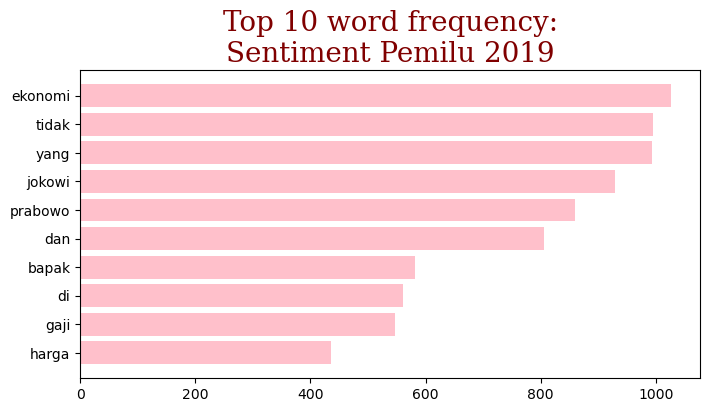

In [55]:
plt.figure(figsize=(8, 4))
font_title = {'family': 'serif', 'color': 'maroon', 'size': 20}

plt.barh(
    list(tokenized_words_sorted.keys())[-10:],
    list(tokenized_words_sorted.values())[-10:], color= 'pink'
)

plt.title('Top 10 word frequency:\nSentiment Pemilu 2019', fontdict=font_title)
plt.show()

## Preparing Model

### Define Target & Label

In [181]:
# Mapping label
map_label = {'negatif': 0, 'netral': 1, 'positif': 2}

# To integer
df_tweet['encoded_lab'] = df_tweet['sentimen'].map(map_label)

# Define X, y
X = df_tweet['stemmed_tweet']
y = df_tweet['encoded_lab']

### Train Test Split

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [183]:
print(len(X))
print(len(y))
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

1815
1815
1452
363
1452
363


## Vectorization

- TF-IDF Vectorizer 
- Melakukan teks vectorizer pada X dan labeling pada Y

In [184]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

#one hot encode
num_classes = len(map_label)
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

### Model

#### Random Forest Algorithm - Criterion = Entropy

In [191]:
# Inisialisasi model RandomForestClassifier dengan hyperparameter tertentu
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1, criterion='entropy')
param_grid = {
    "n_estimators": [50, 100, 150],
    "max_features": ["log2"],
    "class_weight": [None, "balanced"],
    "min_samples_split":[2, 4, 6],
    "min_samples_leaf":[1, 3, 5],
}

# Melatih model pada data training
rf_classifier.fit(X_train, y_train)

# Membuat prediksi pada data test
Y_pred = rf_classifier.predict(X_test)

# Menghitung dan mencetak akurasi
accuracy = accuracy_score(y_test, Y_pred)
print('='*60)
print(f'Accuracy: {accuracy:.2f}')

# Menampilkan classification report
print('Classification Report:')
print(classification_report(y_test, Y_pred))
print('='*60)

Accuracy: 0.57
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.63      0.59       115
           1       0.55      0.60      0.58       118
           2       0.61      0.48      0.54       130

    accuracy                           0.57       363
   macro avg       0.57      0.57      0.57       363
weighted avg       0.57      0.57      0.57       363



In [189]:
#Inisialisasi GridSearch
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

#Mencari model terbaik
best_rf_classifier = grid_search.best_estimator_
best_accuracy = grid_search.best_score_

#Membuat ensemble model
ensemble_rf = VotingClassifier([('rf1', best_rf_classifier), ('rf2', best_rf_classifier), ('rf3', best_rf_classifier)])

#Melatih ensemble model
ensemble_rf.fit(X_train, y_train)

#Mengevaluasi ensemble model
ensemble_accuracy = ensemble_rf.score(X_test, y_test)

In [192]:
print('='*50)
print(f"Best Random Forest Classifier: {best_rf_classifier}")
print(f"Best Random Forest Classifier Accuracy: {best_accuracy*100:.2f}")
print(f"Ensemble Accuracy:{ensemble_accuracy*100:.2f}")
print('='*50)

Best Random Forest Classifier: RandomForestClassifier(criterion='entropy', max_features='log2',
                       min_samples_split=6, n_estimators=150, n_jobs=-1,
                       random_state=42)
Best Random Forest Classifier Accuracy: 62.13
Ensemble Accuracy:60.33


- Random Forest Algorithm - Criterion = Gini

In [193]:
# Inisialisasi model RandomForestClassifier dengan hyperparameter tertentu
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1, criterion='gini')
param_grid = {
    "n_estimators": [1000],
    "max_features": ["log2"],
    "class_weight": [None, "balanced"],
    "min_samples_split":[2],
    "min_samples_leaf":[1]
}

# Melatih model pada data training
rf_classifier.fit(X_train, y_train)

# Membuat prediksi pada data test
Y_pred = rf_classifier.predict(X_test)

# Menghitung dan mencetak akurasi
accuracy = accuracy_score(y_test, Y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Menampilkan classification report
print('='*50)
print('Classification Report:')
print(classification_report(y_test, Y_pred))
print('='*50)

Accuracy: 0.5702
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.65      0.60       115
           1       0.55      0.58      0.56       118
           2       0.60      0.49      0.54       130

    accuracy                           0.57       363
   macro avg       0.57      0.57      0.57       363
weighted avg       0.57      0.57      0.57       363



In [194]:
#Inisialisasi GridSearch
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

#Mencari model terbaik
best_rf_classifier = grid_search.best_estimator_
best_accuracy = grid_search.best_score_

#Membuat ensemble model
ensemble_rf = VotingClassifier([('rf1', best_rf_classifier), ('rf2', best_rf_classifier), ('rf3', best_rf_classifier)])

#Melatih ensemble model
ensemble_rf.fit(X_train, y_train)

#Mengevaluasi ensemble model
ensemble_accuracy = ensemble_rf.score(X_test, y_test)

In [195]:
print('='*50)
print(f"Best Random Forest Classifier: {best_rf_classifier}")
print(f"Best Random Forest Classifier Accuracy: {best_accuracy*100:.2f}")
print(f"Ensemble Accuracy:{ensemble_accuracy*100:.2f}")
print('='*50)

Best Random Forest Classifier: RandomForestClassifier(max_features='log2', n_estimators=1000, n_jobs=-1,
                       random_state=42)
Best Random Forest Classifier Accuracy: 63.22
Ensemble Accuracy:57.30


## Summary

- Tidak seperti LSTM, ketika menggunakan Random Forest ini, tidak banyak eksperimen yang dilakukan. Hanya mengubah hyperparameter seperti criterion dan n_estimator. 
- Kedua criterion menghasilkan akurasi yang sama yaitu 57%
- Ensemble Accuracy:60.33 untuk criterion 'entropy' & Ensemble Accuracy:57.30 untuk criterion 'gini'